<a href="https://colab.research.google.com/github/Yodeman/dog_breed_classifier/blob/main/Dog_breeds_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 8.4MB/s 
     |████████████████████████████████| 51kB 6.9MB/s 
     |████████████████████████████████| 194kB 15.0MB/s 
     |████████████████████████████████| 1.2MB 21.5MB/s 
     |████████████████████████████████| 61kB 10.8MB/s 
Mounted at /content/gdrive


In [3]:
from fastbook import *
from fastai.vision.widgets import *

In [17]:
key = os.environ.get("AZURE_SEARCH_KEY", '6ec2e26e840048eb857be3397f3cb30a')

In [7]:
search_images_bing?

In [18]:
results = search_images_bing(key, 'german shepherd')

In [19]:
imgs = results.attrgot('contentUrl')
len(imgs)

150

In [24]:
os.mkdir('images')
dest = 'images/german.jpg'
download_url(imgs[0], dest)

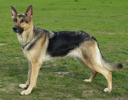

In [25]:
img = Image.open(dest)
img.to_thumb(128, 128)

In [26]:
dog_breeds = ['german', 'caucasian', 'alaskan']
path = Path('dogs')

In [31]:
shutil.rmtree('dogs')

In [32]:
if not path.exists():
    path.mkdir()
    for d in dog_breeds:
        dest = path/d
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{d} shepherd')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [33]:
fns = get_image_files(path)
fns

(#437) [Path('dogs/alaskan/00000021.jpg'),Path('dogs/alaskan/00000134.jpg'),Path('dogs/alaskan/00000076.jpg'),Path('dogs/alaskan/00000059.jpg'),Path('dogs/alaskan/00000129.jpg'),Path('dogs/alaskan/00000119.jpg'),Path('dogs/alaskan/00000105.jpg'),Path('dogs/alaskan/00000148.jpg'),Path('dogs/alaskan/00000110.jpg'),Path('dogs/alaskan/00000014.jpg')...]

In [34]:
failed = verify_images(fns)
failed

(#4) [Path('dogs/alaskan/00000138.jpg'),Path('dogs/german/00000111.jpg'),Path('dogs/caucasian/00000139.jpg'),Path('dogs/caucasian/00000126.jpg')]

In [35]:
failed.map(Path.unlink)

(#4) [None,None,None,None]

In [36]:
dogs = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter = RandomSplitter(seed=42),
    get_y = parent_label,
    item_tfms = Resize(128)
)

In [37]:
dls = dogs.dataloaders(path)

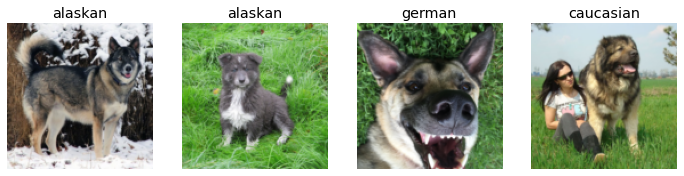

In [39]:
dls.valid.show_batch(max_n=4, nrows=1)

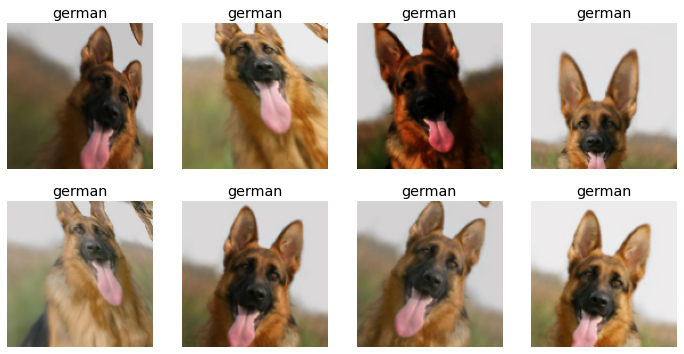

In [40]:
dogs = dogs.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = dogs.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [41]:
dogs = dogs.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms()
)
dls = dogs.dataloaders(path)

In [42]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


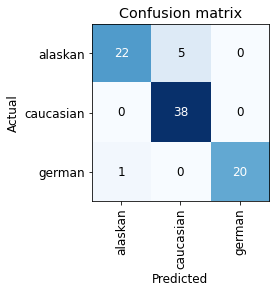

In [43]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

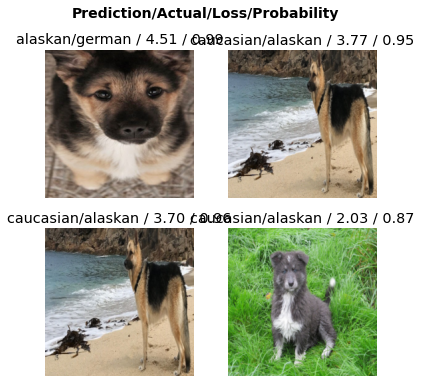

In [48]:
interp.plot_top_losses(4, nrows=2)

In [49]:
# clean dataset
cleaner = ImageClassifierCleaner(learn)
cleaner

In [54]:
learn.export()

In [55]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [56]:
learn_inf = load_learner(path/'export.pkl')

In [57]:
learn_inf.predict('images/german.jpg')

('german', tensor(2), tensor([7.7539e-04, 2.5353e-05, 9.9920e-01]))

In [58]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [59]:
img = PILImage.create(btn_upload.data[-1])

In [60]:
output = widgets.Output()
output.clear_output()
with output: display(img.to_thumb(128, 128))
output

Output()

In [61]:
pred, pred_idx, prob = learn_inf.predict(img)

In [63]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {prob[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: german; Probability: 1.0000')

In [64]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [70]:
btn_upload = widgets.FileUpload()

In [73]:
def classify(change):
    img = PILImage.create(btn_upload.data[-1])
    output.clear_output()
    with output: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(classify)

In [74]:
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, output, lbl_pred])

NameError: ignored